In [2]:
%pylab inline
import pandas as pd

rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False

Populating the interactive namespace from numpy and matplotlib


In [3]:
sample_info = pd.read_csv('BC_sample_info.csv', index_col=0)

df = pd.read_table('data/Layer2_BC_count_matrix-1.tsv', index_col=0)
df = df.loc[sample_info.index]
df = df.T[df.sum(0) >= 3].T  # Filter practically unobserved genes

In [4]:
import NaiveDE

In [5]:
dfm = NaiveDE.stabilize(df.T).T
res = NaiveDE.regress_out(sample_info, dfm.T, 'np.log(total_counts)').T

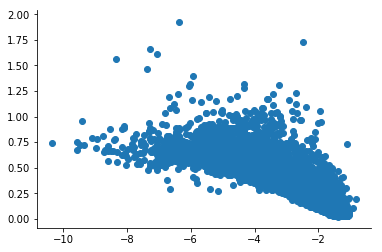

In [6]:
plt.scatter(res.mean(), res.var());

In [7]:
idx = res.var().sort_values(ascending=False).head(1000).index

In [8]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [9]:
pca = PCA()
Y = pca.fit_transform(scale(res[idx], 1))

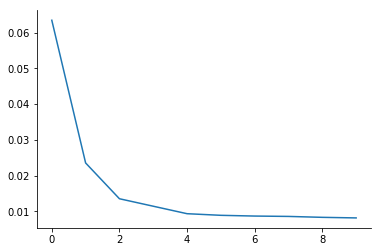

In [10]:
plt.plot(pca.explained_variance_ratio_[:10]);

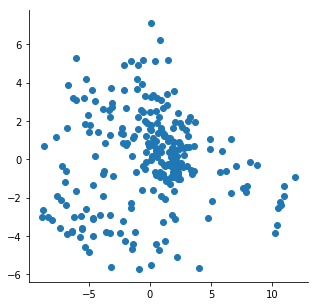

In [11]:
figsize(5, 5)
plt.scatter(Y[:, 0], Y[:, 1]);

In [12]:
from sklearn.mixture import BayesianGaussianMixture

In [13]:
gmm = BayesianGaussianMixture(n_components=20, max_iter=10000)

In [14]:
gmm.fit(Y[:, :2])

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
            degrees_of_freedom_prior=None, init_params='kmeans',
            max_iter=10000, mean_precision_prior=None, mean_prior=None,
            n_components=20, n_init=1, random_state=None, reg_covar=1e-06,
            tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
            weight_concentration_prior=None,
            weight_concentration_prior_type='dirichlet_process')

In [15]:
phi_hat = gmm.predict(Y[:, :2])

In [16]:
sample_info['PC1'] = Y[:, 0]
sample_info['PC2'] = Y[:, 1]
sample_info['cluster'] = phi_hat

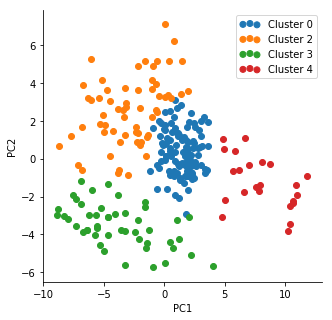

In [17]:
figsize(5, 5)
for i, g in sample_info.groupby('cluster'):
    plt.scatter(g.PC1, g.PC2, label=f'Cluster {i}')
    
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.legend(scatterpoints=3);

In [18]:
gmm

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
            degrees_of_freedom_prior=None, init_params='kmeans',
            max_iter=10000, mean_precision_prior=None, mean_prior=None,
            n_components=20, n_init=1, random_state=None, reg_covar=1e-06,
            tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
            weight_concentration_prior=None,
            weight_concentration_prior_type='dirichlet_process')

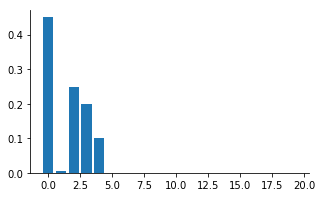

In [19]:
figsize(5, 3)
plt.bar(range(len(gmm.weights_)), gmm.weights_);

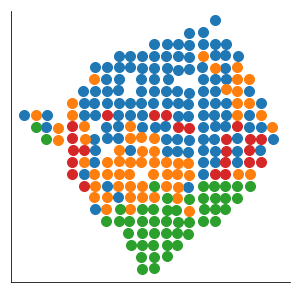

In [20]:
figsize(5, 5)
for i, g in sample_info.groupby('cluster'):
    plt.scatter(g.x, g.y, label=f'Cluster {i}', s=100)
    
plt.xticks([])
plt.yticks([]);
plt.axis('equal');

In [21]:
sample_info['cluster'] = phi_hat

In [22]:
de_results = NaiveDE.lr_tests(sample_info, res.T, '~ C(cluster)')

In [33]:
de_results.query('qval < 0.05').shape

(959, 6)

In [34]:
de_results.shape

(12856, 6)

In [23]:
sde_results = pd.read_csv('BC_final_results.csv', index_col=0)

In [24]:
de_results = de_results.sort_index()
sde_results = sde_results.sort_values('g')

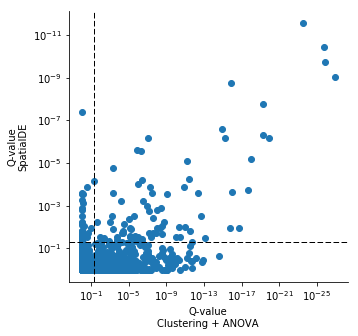

In [25]:
plt.loglog()
plt.scatter(de_results['qval'], sde_results['qval']);
ax = plt.gca()
ax.invert_yaxis()
ax.invert_xaxis();
plt.xlabel('Q-value\nClustering + ANOVA')
plt.ylabel('Q-value\nSpatialDE');

plt.axhline(0.05, color='k', ls='--', lw=1)
plt.axvline(0.05, color='k', ls='--', lw=1);

In [26]:
sde_results.query('qval < 0.05').shape

(114, 17)

In [27]:
sig_genes = sde_results.query('qval < 0.05')['g'].sort_values().values
more_sig = de_results.loc[sig_genes].query('qval > 0.05').sort_values('qval')
more_sig

,Intercept,C(cluster)[T.2],C(cluster)[T.3],C(cluster)[T.4],pval,qval
CLEC3A,-3.860223,-0.404364,0.050756,0.365558,0.000212,0.053082
FCGR3A,-2.693640,0.068936,0.407144,-0.244987,0.000361,0.090367
C2orf40,-1.440299,0.161448,0.001751,-0.057196,0.000760,0.189892
HPS3,-1.937703,-0.087405,0.009301,0.242235,0.000965,0.241234
CXCL13,-1.714558,0.163727,-0.051935,-0.149953,0.001073,0.268306
TFF1,-2.051718,-0.073975,-0.175462,0.172436,0.002054,0.513376
PI15,-1.310726,0.194596,-0.054086,-0.069491,0.002477,0.619239
IGFBP5,-6.626940,-0.480273,0.263460,0.052896,0.002516,0.628894
ACTL8,-1.780693,-0.117443,-0.162483,0.133088,0.006575,1.000000
SAA1,-1.724249,0.215974,-0.250173,-0.002273,0.004577,1.000000


In [28]:
sde_results.query('g in @more_sig.index')[['g', 'l', 'qval']].sort_values('qval')

,g,l,qval
3249,SNAP25,0.641736,4.121108e-08
8785,CLEC3A,1.843940,7.170456e-05
7887,CXCL13,1.087806,1.277761e-04
9519,STC2,1.843940,2.500246e-04
8393,IL12RB1,1.087806,2.764643e-04
11227,PI15,3.125663,2.897039e-04
5336,CXCL9,1.087806,5.367657e-04
8931,IGFBP5,1.843940,7.074985e-04
2837,SSPO,0.641736,1.223581e-03
3461,ZNF880,0.641736,1.589774e-03


In [29]:
more_sig.shape

(32, 6)

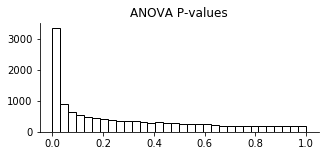

In [37]:
figsize(5, 2)
de_results.pval.hist(bins=32, fc='w', ec='k', grid=False);
plt.title('ANOVA P-values');

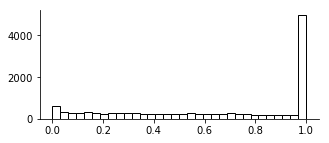

In [31]:
figsize(5, 2)
sde_results.pval.hist(bins=32, fc='w', ec='k', grid=False);

In [35]:
114 - 32

82